# Active Learning Notebook

Use the large data set with active learning.

## Notes 04-27-2022

Did some debugging. The linear model works right now. The GP model is not working currently so have asked Berkay if there are parameters that give some good values. Random runs throught the `multiple_rounds` function, but the accuracy is extremely high at the very start 0.94. This is with 30 training samples. I'm wondering if the data is somehow sorted so that the first 1000 samples that I'm currently using for testing are similar and hence the high accuracy even with only 30 sample for training. Next step is to pre-shuffle the data and see if this makes the early stages of the random have a lower accuracy. 

TODO:

 - [x] pre-shuffle the data (as you recently did in the pace visualization repository).
 - [x] try and get the GPR model working
 - [ ] examine efficiency
   - [ ] do the fit for the PCA only with the training data (not the pooled data)
 - [ ] batch jobs. don't relearn so frequently
 - [ ] parallel
 
 Integerate into ModAL
 
 - [ ] Figure out how to cache the greedy sampling distances and labeled and unlabeled samples
   - [ ] should that data be returned from the query with an updated model. 
   - is there an expectation that the model is updated after the query???
 

## Notes 07-28-2022

We now have a reasonably accurate GPR model. It's accuracy against a test set is 0.84. That isn't marvelous, but acceptable. However, it still doesn't work well with active learning. My current understanding is that this is to do with the lack of variation in the standard deviation between all the samples. Essentially, it takes a lot of samples to generate an accurate model regardless of the samples used to calibrate the model. I'm not sure what this means, but maximum uncertainty active learning doesn't work at all with this data set. It's likely that none of the other methods will do any better.

 - What do we call this sort of data. Data that requires a large number of samples to calibrate regardless of the samples chosen and how optimal the samples are.

### Debugging

One of the confusing issues with the debugging is that the system was selecting the same sample over and over again. The issue is that the way ModAL is set up, it was necessary to keep the pool of data consistent. This is due to how the greedy alogrithms are set up. Anyway, I did the uncertainty sampling outside of the ModAL system. I'll have to rework the way we're using ModAL.

### Next step

Show image of test and train accuracy as the number of samples are increased with different batch numbers for GPR model.

In [1]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
#from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do, merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence
from active import gsx_query, gsy_query, igs_query, multiple_rounds, three_way_split, flatten

import dask.array as da

from itertools import cycle

## Load the data

In [2]:
data = np.load('data_shuffled.npz')

In [3]:
x_data = data['x_data']
y_data = data['y_data'].reshape(-1)

In [4]:
print(x_data.shape)
print(y_data.shape)

(8900, 132651)
(8900,)


## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [5]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], 51, 51,51)
        )),    
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=20, correlations=[(0, 0)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3)),
    )

In [6]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e6)) + WhiteKernel(noise_level=0.05)
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
#    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) + WhiteKernel(noise_level=0.1)
#    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=99)
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [7]:
@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [9]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

## Set up the active learners

One is a GPR using the maximum std and the other is random

In [10]:
from active import make_igs, make_gsx, make_gsy, make_bayes, make_uncertainty, make_ensemble, make_random, make_active

distance_transformer = lambda x: pca_model().fit_transform(x)

#def query_uncertainty(model, x_pool):
#    if not hasattr(model, 'batch_ids') or len(model.batch_ids) == 0:
#        uncertainties = model.predict(x_pool, return_std=True)[1]
#        args = np.argsort(uncertainties)[::-1]
#        model.batch_ids = args[:5]
#    next_item = (model.batch_ids[0], x_pool[model.batch_ids[0]])
#    model.batch_ids = model.batch_ids[1:]
#    print('next id', next_item[0])
#    return next_item

query_uncertainty = lambda model, x_: pipe(
    model.predict(x_, return_std=True)[1],
    np.argmax,
    lambda i: (i, x_[i]), 
    do(lambda x: print('id:', x[0]))
)

def make_learners(x_train, y_train):
    return dict(
        uncertainty=make_active(query_uncertainty)(make_gp_model, x_train, y_train),
#        random=make_random(make_gp_model, x_train, y_train),
#        ensemble=make_ensemble(x_train, y_train),
#        bayes=make_bayes(make_gp_model, x_train, y_train),
#        gsx=make_gsx(distance_transformer)(make_linear_model, x_train, y_train),
#        gsy=make_gsy(make_linear_model, x_train, y_train),
#        igs=make_igs(distance_transformer)(make_linear_model, x_train, y_train)
    )

#random_learner = make_random(make_gp_model, x_train, y_train)

## Check the data

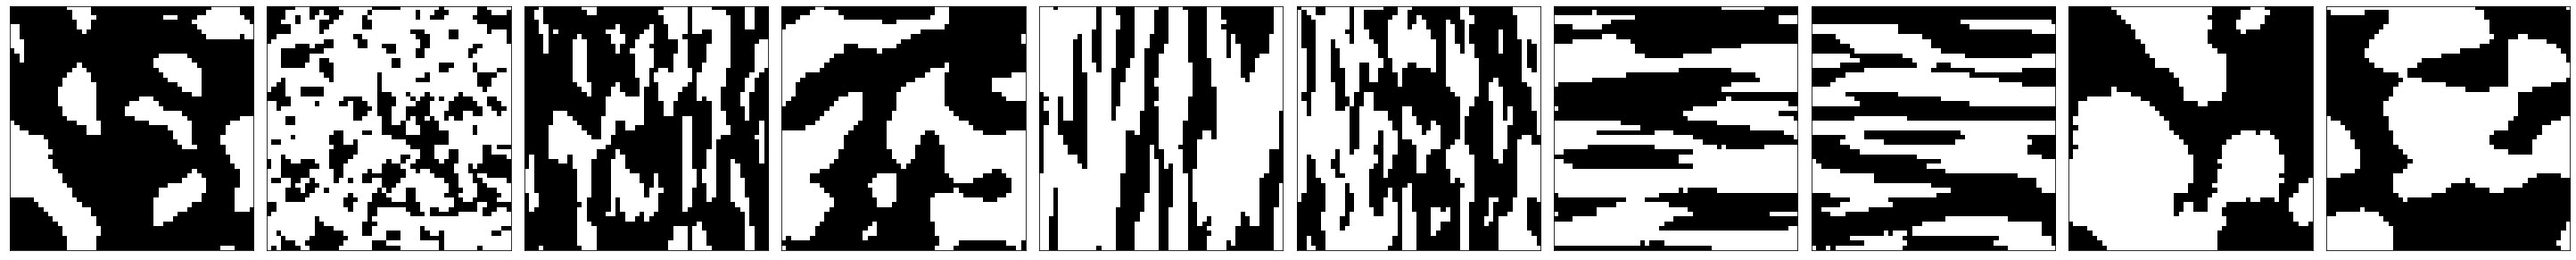

In [11]:
plot_microstructures(*x_data[:10].reshape(10, 51, 51, 51)[:, :, :, 0], cmap='gray', colorbar=False);

In [12]:
n_use = 2000
props = (0.93, 0.05)

x_pool, x_test, x_train, y_pool, y_test, y_train, indices_pool, indices_test, indices_train = three_way_split(x_data[:n_use], y_data[:n_use], props, None)

In [13]:
print(indices_train)

[1061  443   78 1107 1515  162  816 1390 1812 1380  532  240  814  604
 1620 1323  269 1493  477  949  455  805 1754 1463  238 1564   68 1614
 1253 1217    2 1505 1348   61 1461   86  387 1831 1027  213]


In [14]:
print(x_pool.shape)
print(x_test.shape)
print(x_train.shape)

(1860, 132651)
(100, 132651)
(40, 132651)


In [15]:
print(y_pool.shape)
print(y_test.shape)
print(y_train.shape)

(1860,)
(100,)
(40,)


## Test the model

In [16]:
model = make_gp_model()
#model = make_linear_model()

In [173]:
model.fit(x_pool, y_pool)

Pipeline(steps=[('reshape',
                 GenericTransformer(func=<function pca_steps.<locals>.<lambda> at 0x7ef9f4fe71f0>)),
                ('discritize', PrimitiveTransformer()),
                ('correlations',
                 TwoPointCorrelation(correlations=[(0, 0)], cutoff=20)),
                ('flatten',
                 GenericTransformer(func=<function pca_steps.<locals>.<lambda> at 0x7ef9f4fe74c0>)),
                ('pca', IncrementalPCA(n_components=3)),
                ('poly', PolynomialFeatures(degree=3)),
                ('regressor',
                 GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.05),
                                          n_restarts_optimizer=10))])

In [52]:
%%timeit
y_pool_predict = model.predict(x_pool)

29.4 s ± 222 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit
y_pool_predict = model.predict(x_pool)

29.3 s ± 2.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [174]:
y_pool_predict, pool_std = model.predict(x_pool, return_std=True)

In [175]:
y_test_predict = model.predict(x_test)

In [176]:
print(np.sort(pool_std))

[ 9.37734734  9.37742922  9.37746959 ... 12.54727643 12.70052686
 12.89884718]


<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

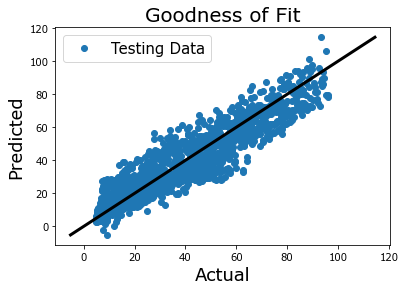

In [177]:
plot_parity(y_pool, y_pool_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

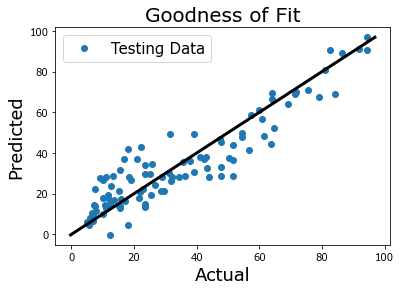

In [178]:
plot_parity(y_test, y_test_predict)

In [179]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))

0.8480806563178547
0.8480806563178547


## Debug

In [21]:
def query_uncertainty(model, x_pool):
    stds = model.predict(x_pool, return_std=True)[1]
    return np.argsort(stds)[::-1][:1]

def evaluate_model(x_data, y_data, model, train_ids, test_ids, pool_ids, query_func, batch_size):
    x_train, y_train = x_data[train_ids], y_data[train_ids]
    x_test, y_test = x_data[test_ids], y_data[test_ids]
    
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    
    ids = query_func(model, x_pool)
    new_ids = pool_ids[ids]
    train_ids = np.append(train_ids, new_ids[:batch_size])
    
    print('before', len(pool_ids))
    print(new_ids[:batch_size])
    print(pool_ids)
    pool_ids = pool_ids[~np.isin(pool_ids, new_ids[:batch_size])]
    print('after', len(pool_ids))
    return model, train_ids, pool_ids, train_score, test_score

In [ ]:
x_pool, x_test, x_train, y_pool, y_test, y_train, pool_ids, test_ids, train_ids = three_way_split(x_data[:n_use], y_data[:n_use], props, 99)

model = make_gp_model()

for _ in range(10):
    model, train_ids, pool_ids, train_score, test_score = evaluate_model(
        x_data[:n_use],
        y_data[:n_use],
        model,
        train_ids,
        test_ids,
        pool_ids, 
        query_uncertainty, 
        10
    )
    print('train score:', train_score)
    print('test_score:', test_score)
    print(len(train_ids))
    print(len(pool_ids))


before 1860
[120]
[ 686  167 1676 ... 1209 1059  641]
after 1859
train score: 0.6483969624502712
test_score: 0.6287404536407492
41
1859
before 1859
[1630]
[ 686  167 1676 ... 1209 1059  641]
after 1858
train score: 0.6416904120592055
test_score: 0.6249280600757459
42
1858
before 1858
[1773]
[ 686  167 1676 ... 1209 1059  641]
after 1857
train score: 0.6553563941989309
test_score: 0.6227018512043179
43
1857
before 1857
[507]
[ 686  167 1676 ... 1209 1059  641]
after 1856
train score: 0.6488627654821775
test_score: 0.6215505500914213
44
1856
before 1856
[571]
[ 686  167 1676 ... 1209 1059  641]
after 1855
train score: 0.9999985028005025
test_score: -2.165037070689613
45
1855
before 1855
[393]
[ 686  167 1676 ... 1209 1059  641]
after 1854
train score: 0.6816108694839007
test_score: 0.624471759634694
46
1854
before 1854
[1982]
[ 686  167 1676 ... 1209 1059  641]
after 1853
train score: 0.6905712091380898
test_score: 0.623126468298246
47
1853
before 1853
[409]
[ 686  167 1676 ... 1209 1059

## Run the learners (linear model)

In [29]:
scores = multiple_rounds(x_data[:n_use], y_data[:n_use], 1, 10, make_learners, oracle_func, props, 99)

indices_test [ 819 1599 1008  885  132 1451  259 1039 1973 1202 1393  618  253 1236
    2  865 1203 1821  248  174  168  917   86  614 1331 1568 1846  561
 1736 1004  115 1814  407  640 1330  832  758    9 1530 1435 1214  976
 1726  111  433 1580 1414  218 1494  333 1864  208  137  962    6 1124
  152  817  317 1906 1750  851 1732 1364  947  780  580   16 1849   26
  261 1320 1898  689 1892  797 1389 1501 1253  390 1621  494 1293 1624
 1211 1775  442 1927  382  937 1791 1862  778  396 1487  828  217  538
 1613  982]
indices_train [ 858  304  583  385 1407 1486 1544 1054  752  171 1753 1277  436  996
  945 1680 1401  721 1162 1357  718 1857  651 1129 1404 1027 1659  809
 1103  146 1049  232 1572 1916 1602 1703 1088  500  419  202]
evaluating uncertainty


  0%|          | 0/10 [00:00<?, ?it/s]

id: 1418


 20%|██        | 2/10 [00:32<02:09, 16.19s/it]

id: 1418


 30%|███       | 3/10 [01:04<02:38, 22.70s/it]

id: 1418


 40%|████      | 4/10 [01:37<02:40, 26.81s/it]

id: 1003


 50%|█████     | 5/10 [02:10<02:24, 28.88s/it]

id: 1003


 60%|██████    | 6/10 [02:44<02:01, 30.47s/it]

id: 390


 70%|███████   | 7/10 [03:17<01:34, 31.43s/it]

id: 390


 80%|████████  | 8/10 [03:50<01:03, 31.79s/it]

id: 249


 90%|█████████ | 9/10 [04:23<00:32, 32.34s/it]

id: 249


100%|██████████| 10/10 [04:56<00:00, 29.69s/it]


id: 390


In [30]:
scores

{'uncertainty': (array([ 0.68904719,  0.68974073,  0.69008438,  0.6903726 ,  0.68930675,
          0.68994369,  0.69033386,  0.69071379,  0.68931731,  0.68853305,
         -2.28791773]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))}

In [31]:
scores

{'uncertainty': (array([ 0.68904719,  0.68974073,  0.69008438,  0.6903726 ,  0.68930675,
          0.68994369,  0.69033386,  0.69071379,  0.68931731,  0.68853305,
         -2.28791773]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))}

(0.0, 1.0)

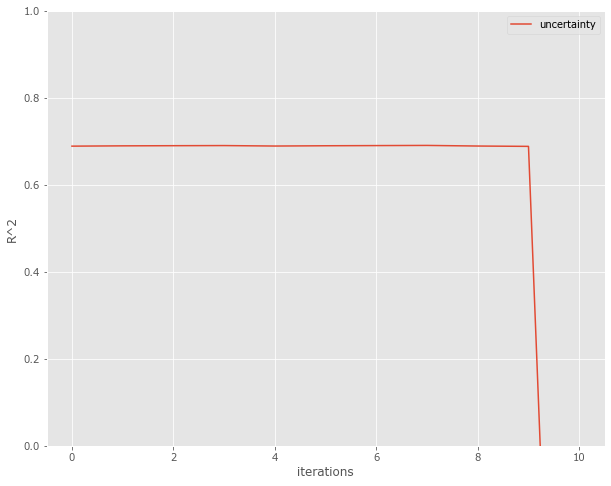

In [33]:
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k, linestyle=next(linecycler))
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

## Run the learners (GP model)

In [14]:
scores = multiple_rounds(x_data[:n_use], y_data[:n_use], 1, 20, make_learners, oracle_func, props, 99)

evaluating uncertainty


100%|██████████| 20/20 [05:16<00:00, 15.80s/it]


evaluating random


100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


evaluating bayes


100%|██████████| 20/20 [05:28<00:00, 16.41s/it]


evaluating gsx


100%|██████████| 20/20 [05:37<00:00, 16.88s/it]


evaluating gsy


100%|██████████| 20/20 [05:26<00:00, 16.34s/it]


evaluating igs


100%|██████████| 20/20 [09:38<00:00, 28.90s/it]


In [15]:
scores


{'uncertainty': (array([ 0.56338491,  0.56261501,  0.56241542,  0.6089452 ,  0.62341315,
          0.62559374, -2.30585858, -2.30587505, -2.30587362, -2.30587505,
          0.75620825, -2.30587505,  0.42593145,  0.33812503,  0.31843733,
          0.62564616,  0.30494424,  0.24395588, -2.30410289,  0.35292066,
         -0.34776795]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.])),
 'random': (array([0.56338491, 0.57827383, 0.58187398, 0.59401296, 0.59397805,
         0.61836939, 0.62941761, 0.63709403, 0.64032037, 0.74286012,
         0.75542221, 0.75728636, 0.73888593, 0.7123319 , 0.74985073,
         0.76956591, 0.63018141, 0.76431861, 0.78778076, 0.77083507,
         0.7544838 ]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.])),
 'bayes': (array([ 0.56338491, -0.00659136,  0.62108636,  0.75476722,  0.68497973,
          0.68324156, -2.30587505, -2.30587505,  0.71791255, -2


## The results

(0.0, 1.0)

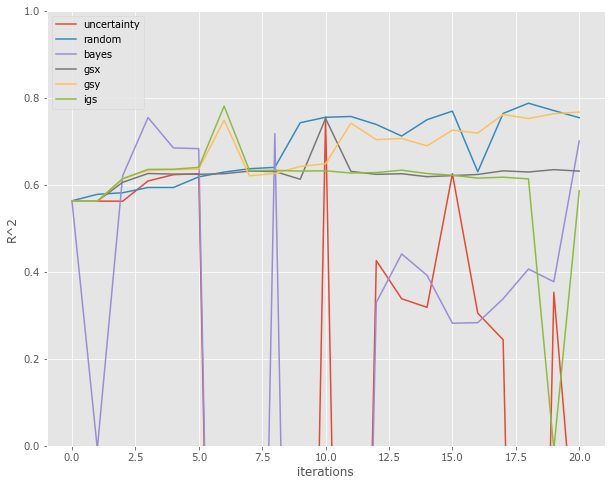

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

(0.9, 1.0)

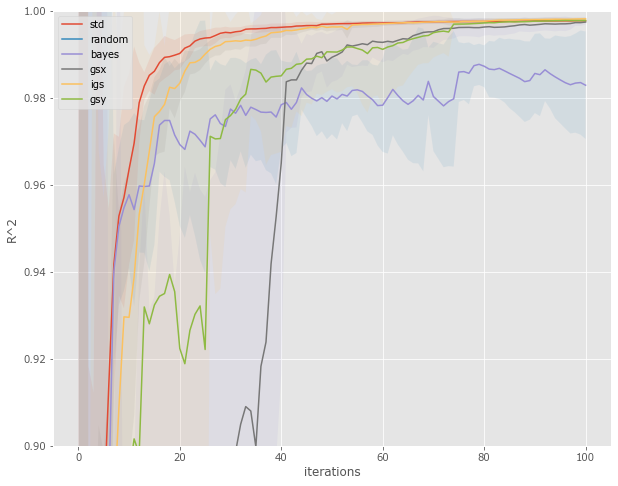

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

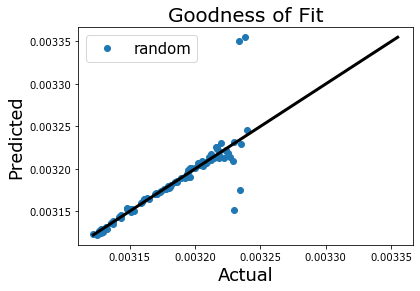

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

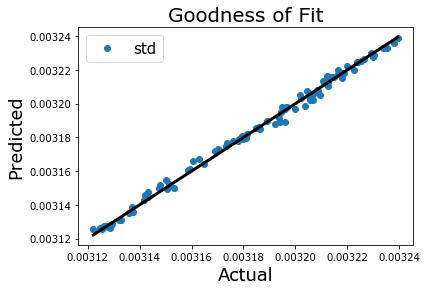

In [90]:
plot_parity(y_test, y_pred_std, label='std')